In [ ]:
import torch
import torch.nn as nn
import seaborn as sns
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, confusion_matrix, classification_report

# Defining neural network architecture

class MyNet(nn.Module):
  def __init__(self,in_channels, out_channels,n_classes):
    super(MyNet,self).__init__()

    self.conv1 = nn.Conv2d(1,16,kernel_size = 3, stride = 1, padding = 1)
    self.relu1 = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv2 = nn.Conv2d(16,32,kernel_size = 3, stride = 1, padding = 1)
    self.relu2 = nn.ReLU()
    self.fc1 = nn.Linear(4608, 256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,64)
    self.fc5 = nn.Linear(64, n_classes)
    self.relu3 = nn.ReLU()
    self.relu4 = nn.ReLU()
    self.relu5 = nn.ReLU()
    self.relu6 = nn.ReLU()
    self.relu7 = nn.ReLU()

  def forward(self,x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.maxpool(out)
    out = self.conv2(out)
    out = self.relu2(out)
    out = self.maxpool(out)
    out = out.view(out.size(0),-1)
    out = self.fc1(out)
    out = self.relu3(out)
    out = self.fc2(out)
    out = self.relu4(out)
    out = self.fc3(out)
    out = self.relu5(out)
    out = self.fc4(out)
    out = self.relu6(out)
    out = self.fc5(out)
    out = self.relu7(out)
    return out

# Customizing dataset class
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

In [ ]:
# Loading and preprocessing the dataset
df = pd.read_csv('ina.csv')
features = df.iloc[:, :-1]
labels = df.iloc[:, -1]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Converting the data to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

X_train = X_train.view(-1, 1, 50, 50)
X_test = X_test.view(-1, 1, 50, 50)

# Creating DataLoader objects for training and testing sets
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)



train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Defining the model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 64
num_classes = 2

model = MyNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 40

for epoch in range(num_epochs):
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Evaluation
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        total_samples += targets.size(0)
        total_correct += (predicted == targets).sum().item()

accuracy = total_correct / total_samples
print(f'Test accuracy: {accuracy}')


In [ ]:
num_epochs = 40
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_correct_train = 0
    total_samples_train = 0
    total_loss_train = 0.0

    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, dim=1)
        total_samples_train += targets.size(0)
        total_correct_train += (predicted == targets).sum().item()
        total_loss_train += loss.item()

    epoch_loss = total_loss_train / len(train_dataloader)
    epoch_accuracy = total_correct_train / total_samples_train

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

# Evaluation
model.eval()
total_correct = 0
total_samples = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        total_samples += targets.size(0)
        total_correct += (predicted == targets).sum().item()

        true_labels.extend(targets.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = total_correct / total_samples
print(f'Test accuracy: {accuracy}')

# Calculating F1 score and recall
f1 = f1_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Test F1 score: {f1}')
print(f'Test recall: {recall}')

# Drawing the confusion matrix plot using Seaborn
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting training loss and accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()

In [ ]:
# Plotting training loss and accuracy separately
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
pretrained_weights = torch.load('nnna.pth')
model.load_state_dict(pretrained_weights)

<All keys matched successfully>

In [ ]:

# Evaluation
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        total_samples += targets.size(0)
        total_correct += (predicted == targets).sum().item()

accuracy = total_correct / total_samples
print(f'Test accuracy: {accuracy}')


Test accuracy: 0.9982897630100172


Test accuracy: 0.9982897630100172
Test F1 score: 0.9978385981810609
Test recall: 0.9981199802389218


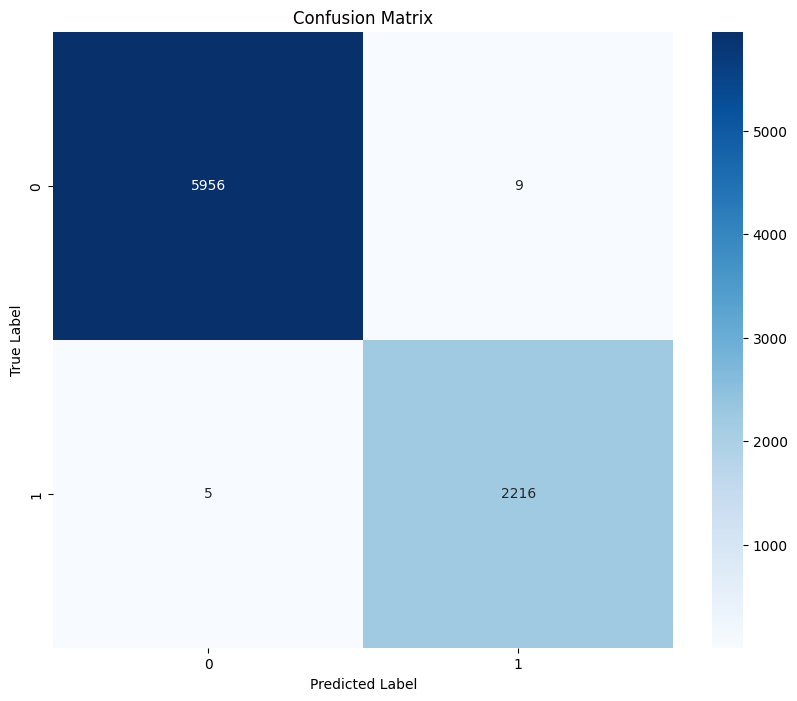

In [ ]:

# Evaluation
model.eval()
total_correct = 0
total_samples = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        total_samples += targets.size(0)
        total_correct += (predicted == targets).sum().item()

        true_labels.extend(targets.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = total_correct / total_samples
print(f'Test accuracy: {accuracy}')

# Calculating F1 score and recall
f1 = f1_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Test F1 score: {f1}')
print(f'Test recall: {recall}')

# Drawing the confusion matrix plot using Seaborn
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()